<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista1_ARIMA_AR_MA_BTCUSD_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
!pip install statsmodels

In [ ]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.4 MB/s eta 0:00:00


# Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

## Statistical Tests

In [ ]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test')
    dftest = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(dftest[0:4],index=labels)

    for key,val in dftest[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())

    if dftest[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    print()

def kpss_value(series):
    import statsmodels.api as sm # Importing statsmodels
    from statsmodels.tools.sm_exceptions import InterpolationWarning
    import warnings
    kpss = None
    # Suprimir apenas o InterpolationWarning ao executar o KPSS
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=InterpolationWarning)
      kpss= sm.tsa.stattools.kpss(series.dropna().values.reshape(-1), nlags='auto')[1]
    return kpss

def kpss_test(series):

    print('Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)')
    print('H0: Data is non-stationary')
    print('Result:')
    kpss = kpss_value(series)
    alpha=0.05
    print(f'* p-value = {round(kpss,2)}. alpha = {round(alpha,2)}')
    if(kpss<=alpha):
        print('* Series is non-stationary; differencing is required.')
    else:
        print('* Series is stationary; no differencing required.')
    print()


def ljungbox_test(series):
    """
    Aplica o teste de Ljung-Box para verificar autocorrelação dos dados.
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox

    ljung_box_results = acorr_ljungbox(series, return_df=True, lags=[20])

    p_value = ljung_box_results['lb_pvalue'].values[0]
    print('\nLJung-Box Test\nH0:has no autocorrelation')
    alpha = 0.05
    print(f'p-valor = {round(p_value,2)}\nalpha = {round(alpha,2)}')
    if p_value > alpha:
        print('Data has no autocorrelation')
    else:
        print('Data has autocorrelation')
    print()

def stationary_test(series):
  print('==============')
  print('ORGINAL SERIES')
  print('==============')
  adf_test(series)

  print('==============')
  print('1st DIFF')
  print('==============')
  diff1 = series.copy()
  diff1['y'] = diff1['y'].diff(1)
  diff1.dropna(inplace=True)
  adf_test(diff1)
  kpss_test(diff1)
  print()


  print('==============')
  print('2st DIFF')
  print('==============')
  diff2 = diff1.copy()
  diff2['y'] = diff2['y'].diff(1)
  diff2.dropna(inplace=True)
  adf_test(diff2)
  kpss_test(diff2)

## Evaluation Metrics

In [ ]:

def prediction_metrics(test, predictions, model=None):
  test_log = np.exp(test['y'])
  pred_log = np.exp(predictions)
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test_log, pred_log)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test_log, pred_log)
  r2 = r2_score(test_log, pred_log)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test_log - pred_log) / test_log)) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test_log - pred_log) /
                (np.abs(test_log) + np.abs(pred_log))) * 100
  values = pd.DataFrame({'model':[model],'mse':[mse],'rmse':[rmse],'mae':[mae],'r2':[r2],'mape':[mape],'smape':[smape]})
  return values



def model_metrics(fitted, model=None):

  aic = fitted.aic
  bic = fitted.bic
  hqic = fitted.hqic
  llf = fitted.llf  # log-likelihood da função de verossimilhança
  values = pd.DataFrame({'model':[model],'aic':[aic],'bic':[bic],'hqic':[hqic],'llf':[llf]})
  return values




## Model Evaluation

In [ ]:
def inc_prediction(train, test, p, d, q):
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)

  history = [ x for x in train.values.reshape(-1)]
  pred = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    pred.append(yhat)
    obs = test['y'].iloc[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
  return pred, model_fit

def _model_name(p,d,q):
  name = None
  if (p==0 and d==0):
    name = f'MA({q})'
  elif (q==0 and d ==0):
    name = f'AR({p})'
  else:
    name = f'ARIMA({p},{d},{q})'
  return name


def model_evaluation(train, test, p, d, q):
  f1, m1 = __model_evaluation(train, test, p, d, q, inc=False)
  f2, m2 = __model_evaluation(train, test, p, d, q, inc=True)
  f = pd.concat([f1,f2],axis=0)
  m = pd.concat([m1,m2],axis=0)
  return f, m


def __model_evaluation(train, test, p, d, q, inc=False):
  model_name = _model_name(p,d,q)
  suf = 'single' if not inc else 'incremental'
  model_name += f'({suf}_testing)'
  print('=================================')
  print(model_name)
  print('=================================')


  if not inc:
    model = ARIMA(train, order=(p,d,q))
    fitted = model.fit()
    pred = fitted.forecast(len(test))
  else:
    pred, fitted = inc_prediction(train, test, p, d, q)

  resid = pd.Series(fitted.filter_results.standardized_forecasts_error[0])

  print('------------------')
  print('MODELO')
  print('------------------')
  print(fitted.summary())
  mdl_metrics = model_metrics(fitted, model=model_name)
  print('-------------------')
  print('RESÍDUO')
  print('-------------------')
  print(resid.describe())
  ljungbox_test(resid)
  print()
  adf_test(resid)
  fitted.plot_diagnostics(figsize=(18,12))
  plt.show()

  print('-------------------')
  print('PREVISÃO')
  print('-------------------')

  plt.figure()
  train['y'].plot(legend=True, label='TRAIN')
  test['y'].plot(legend=True, label='TEST')
  pd.DataFrame({'ds':test.index, 'y':pred}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
  plt.show()

  pred_metrics = prediction_metrics(test, pred, model=model_name)
  print(pred_metrics)
  return pred_metrics, mdl_metrics

## ACF and PACF

In [ ]:
def plot_acf_pacf(series, lags=15, title='series'):
  fig, axes = plt.subplots(1,3, figsize=(20,5))
  axes[0].plot(series); axes[0].set_title(title)
  plot_acf(series, ax=axes[1],lags=lags)
  plot_pacf(series, ax=axes[2],lags=lags)

  # Rotaciona os rótulos do eixo X apenas nos gráficos à esquerda
  for ax in axes[:]:
      for label in ax.get_xticklabels():
          label.set_rotation(45)

  fig.tight_layout()
  fig.show()

def plot_diff1(series, lags=15, title='1st diff series'):
  diff1 = series.copy()
  diff1['y'] = diff1['y'].diff(1)
  diff1.dropna(inplace=True)
  plot_acf_pacf(diff1, lags=lags, title=title)
  return diff1

def plot_acf_pacf_diff(series, lags=15):
  plot_acf_pacf(series, lags=lags)
  diff1_kpss = None
  diff2_kpss = None
  data_kpss = kpss_value(series)
  if (data_kpss <= 0.05):
    diff1 = plot_diff1(series, lags=lags)
    diff1_kpss = kpss_value(diff1)
    if (diff1_kpss <= 0.05):
      diff2 = plot_diff1(diff1, lags=lags, title='2nd diff series')
      diff2_kpss = kpss_value(diff2)
  return data_kpss, diff1_kpss, diff2_kpss

# Load Data

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SERIES'}, xlabel='Date'>

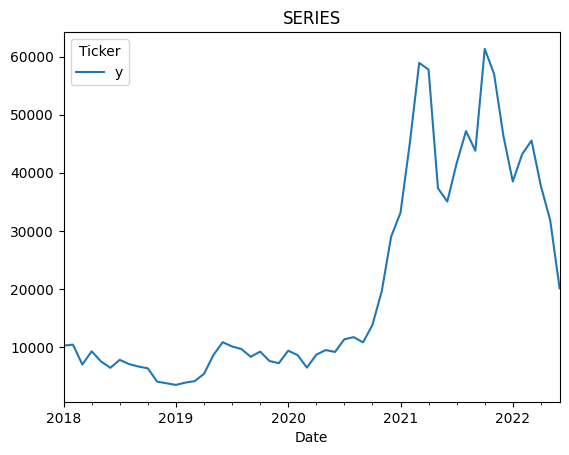

In [ ]:
start_date = datetime(2018, 1, 1)
end_date = datetime (2022, 6, 30)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()
df.plot(title="SERIES")

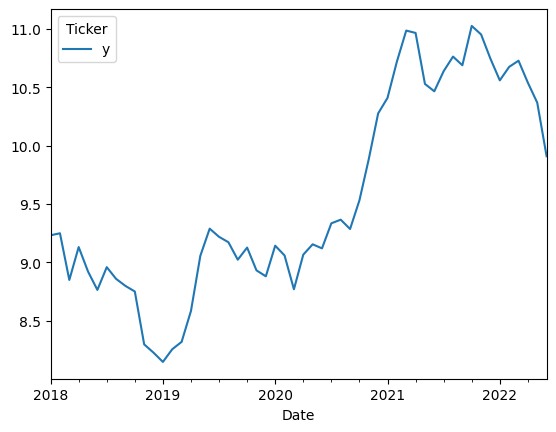

In [ ]:
log_flag = 1
if log_flag == 1:
  df=np.log(df)
  df.plot()

# Train / Test

train.shape=(37, 1)
test.shape=(17, 1)


<Axes: title={'center': 'TRAIN'}, xlabel='Date'>

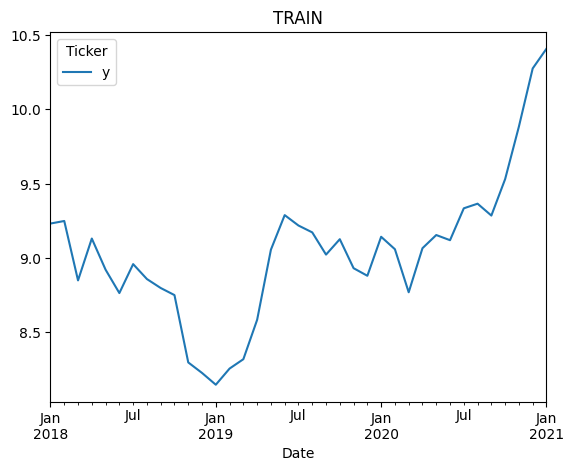

In [ ]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(f'train.shape={train.shape}')
print(f'test.shape={test.shape}')
train.plot(title='TRAIN')


# Analysis

## Methodology

**1. Estacionariedade**

"Os logaritmos estabilizam a variância, enquanto a diferença sazonal remove a sazonalidade e a tendência (...)

Há vários testes de raiz unitária disponíveis, que são baseados em diferentes suposições e podem levar a respostas conflitantes. Em nossa análise, usamos o teste de Kwiatkowski-Phillips-Schmidt-Shin (KPSS) (Kwiatkowski et al., 1992). Neste teste, a hipótese nula é que os dados são estacionários, e procuramos evidências de que a hipótese nula é falsa. Consequentemente, valores-p pequenos (por exemplo, menores que 0,05) sugerem que a diferenciação é necessária." [1]

**2. Diferenciação**

"Um modelo estreitamente relacionado permite que as diferenças tenham uma média diferente de zero. (...) O valor de c é a média das mudanças entre observações consecutivas. Se c for positivo, então a mudança média é um aumento no valor de yt. Assim, yt tenderá a aumentar. No entanto, se c for negativo, yt tenderá a diminuir. Este é o modelo por trás do método Drift (...)

Ocasionalmente, os dados diferenciados podem não parecer estacionários, e pode ser necessário diferenciar os dados uma segunda vez para obter uma série estacionária (...) se os dados tiverem um padrão sazonal forte, recomendamos que a diferenciação sazonal seja feita primeiro, pois a série resultante às vezes será estacionária e não haverá necessidade de uma primeira diferenciação adicional. Se a primeira diferenciação for feita primeiro, ainda haverá sazonalidade presente. (...)

Tenha cuidado ao aplicar mais diferenciações do que o necessário, pois isso pode induzir dinâmicas ou autocorrelações falsas que não existem realmente na série temporal. Portanto, faça o mínimo de diferenciações necessário para obter uma série estacionária. (...) É importante que, se a diferenciação for utilizada, as diferenças sejam interpretáveis." [1]

**3. ACF e PACF**

"Se os dados seguem um modelo ARIMA(p,d,0) ou ARIMA(0,d,q), os gráficos de ACF e PACF podem ser úteis para determinar os valores de p ou q. Se p e q forem ambos positivos, os gráficos não ajudam na escolha dos valores apropriados de p e q.

Os dados podem seguir um modelo ARIMA(p,d,0) se os gráficos de ACF e PACF dos dados diferenciados apresentarem os seguintes padrões:

* a ACF decai exponencialmente ou tem um padrão sinusoidal;
* há um pico significativo na defasagem p da PACF, mas nenhum além da defasagem p.

Os dados podem seguir um modelo ARIMA(0,d,q) se os gráficos de ACF e PACF dos dados diferenciados mostrarem os seguintes padrões:

* a PACF decai exponencialmente ou tem um padrão sinusoidal;
* há um pico significativo na defasagem q da PACF, mas nenhum além da defasagem q." [2]

O valor de p ou q será a última defasagem com pico significativo no gráfico PACF ou ACF, respectivamente. [2]

**Referência Bibliográfica**
* [1] https://otexts.com/fpppg/stationarity.html
* [2] https://otexts.com/fpppg/non-seasonal-arima.html

## Differentiation and tests

In [ ]:
stationary_test(train)

ORGINAL SERIES
Augmented Dickey-Fuller Test
ADF test statistic      -0.220743
p-value                  0.936003
# lags used              1.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

1st DIFF
Augmented Dickey-Fuller Test
ADF test statistic      -4.953736
p-value                  0.000027
# lags used              0.000000
# observations          35.000000
critical value (1%)     -3.632743
critical value (5%)     -2.948510
critical value (10%)    -2.613017
Reject the null hypothesis
Data has no unit root and is stationary

Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)
H0: Data is non-stationary
Result:
* p-value = 0.07. alpha = 0.05
* Series is stationary; no differencing required.


2st DIFF
Augmented Dickey-Fuller Test
ADF test statistic     -7.983922e+00
p-value                 2.579208e-12
# lags used        

## Plotting

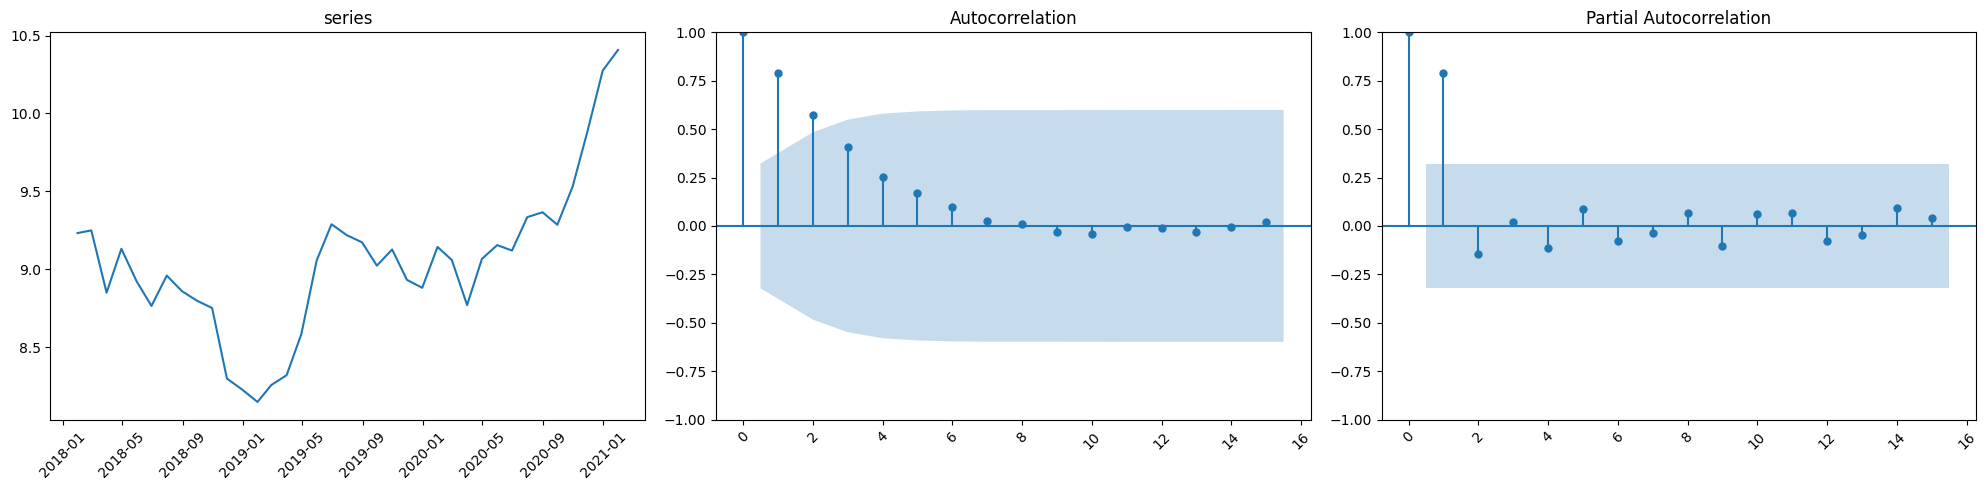

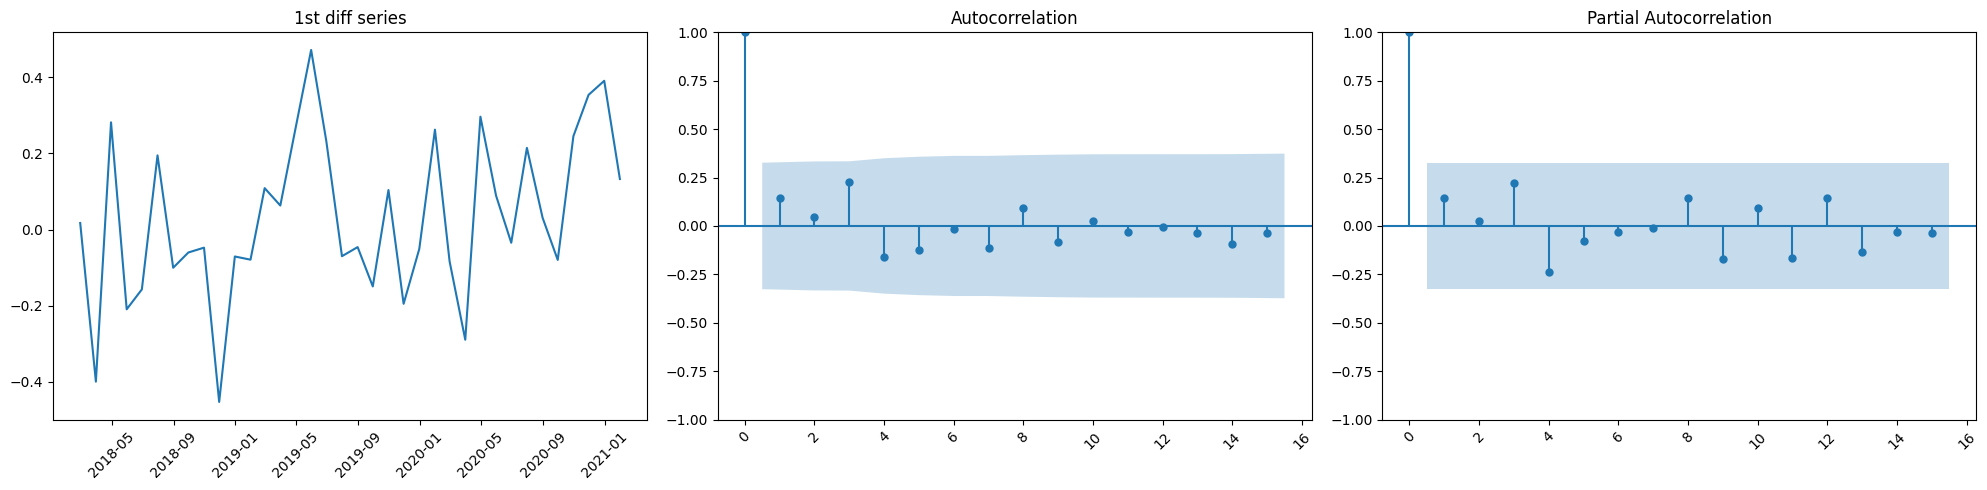

In [ ]:

_,_,_ = plot_acf_pacf_diff(train)

## Conclusion

**REVISAR**:

Após a 1ª diferenciação, os testes ADF e KPSS divergiram a cerca da estacionariedade dos dados, por isso uma 2ª diferenciação foi realizada.

Visualmente a séria com a duplamente diferenciada é bastante estacionária, enquanto a com 1ª diferenciação possui um certo aumento de variância a partir de novembro de 2020. Sendo assim, devemos considerar o hiper-parâmetro 'd' como igual a 2.  

No contexto da 2ª diferenciação, o gráfico ACF mostra que o lag 1 está fora da banda de confiança, podendo o hiper-parâmetro 'q' ser igual a 1. Quanto ao gráfico PACF, o último lag fora da banda de confianção é o 2, podendo ser este o valor do hiper-parâmetro 'p'.

Contudo, como os testes ADF e KPSS discordaram na 1ª diferenciação, e os lags mais significativos da série duplamente diferenciada se tornaram negativos, realizarei experimentos não só com esta, mas também com a primeira, objetivando, assim, afastar qualquer alegação de superdiferenciação. Sendo assim, no contexto da 1ª diferenciação, os valores para os hiperparâmetros 'p', 'd' e 'q' poderiam ser todos iguais a 1.

Por fim, realizarei a comparação dos modelos com base nos critérios AIC e BIC, tanto para a série com primeira quanto com segunda diferenciação. Além disso, será conduzido um experimento com o AutoARIMA, com o objetivo de descartar qualquer indício de superdiferenciação e, assim, confirmar a adequação, ou não, da segunda diferenciação. Ressalte-se, ainda, que como os hiperparâmetros 'p' e 'q' apresentaram valores distintos de zero — indicando a presença de lags significativos em ambos os componentes —, serão realizados testes adicionais omitindo cada um deles isoladamente, conforme orientações estabelecidas na seção de Metodologia.

# Modelo ARIMA

## ARIMA(0,1,0)

ARIMA(0,1,0)(single_testing)
------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:                 ARIMA(0, 1, 0)   Log Likelihood                   4.022
Date:                Tue, 15 Apr 2025   AIC                             -6.044
Time:                        01:00:59   BIC                             -4.460
Sample:                    01-31-2018   HQIC                            -5.491
                         - 01-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0468      0.013      3.745      0.000       0.022       0.071
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera 

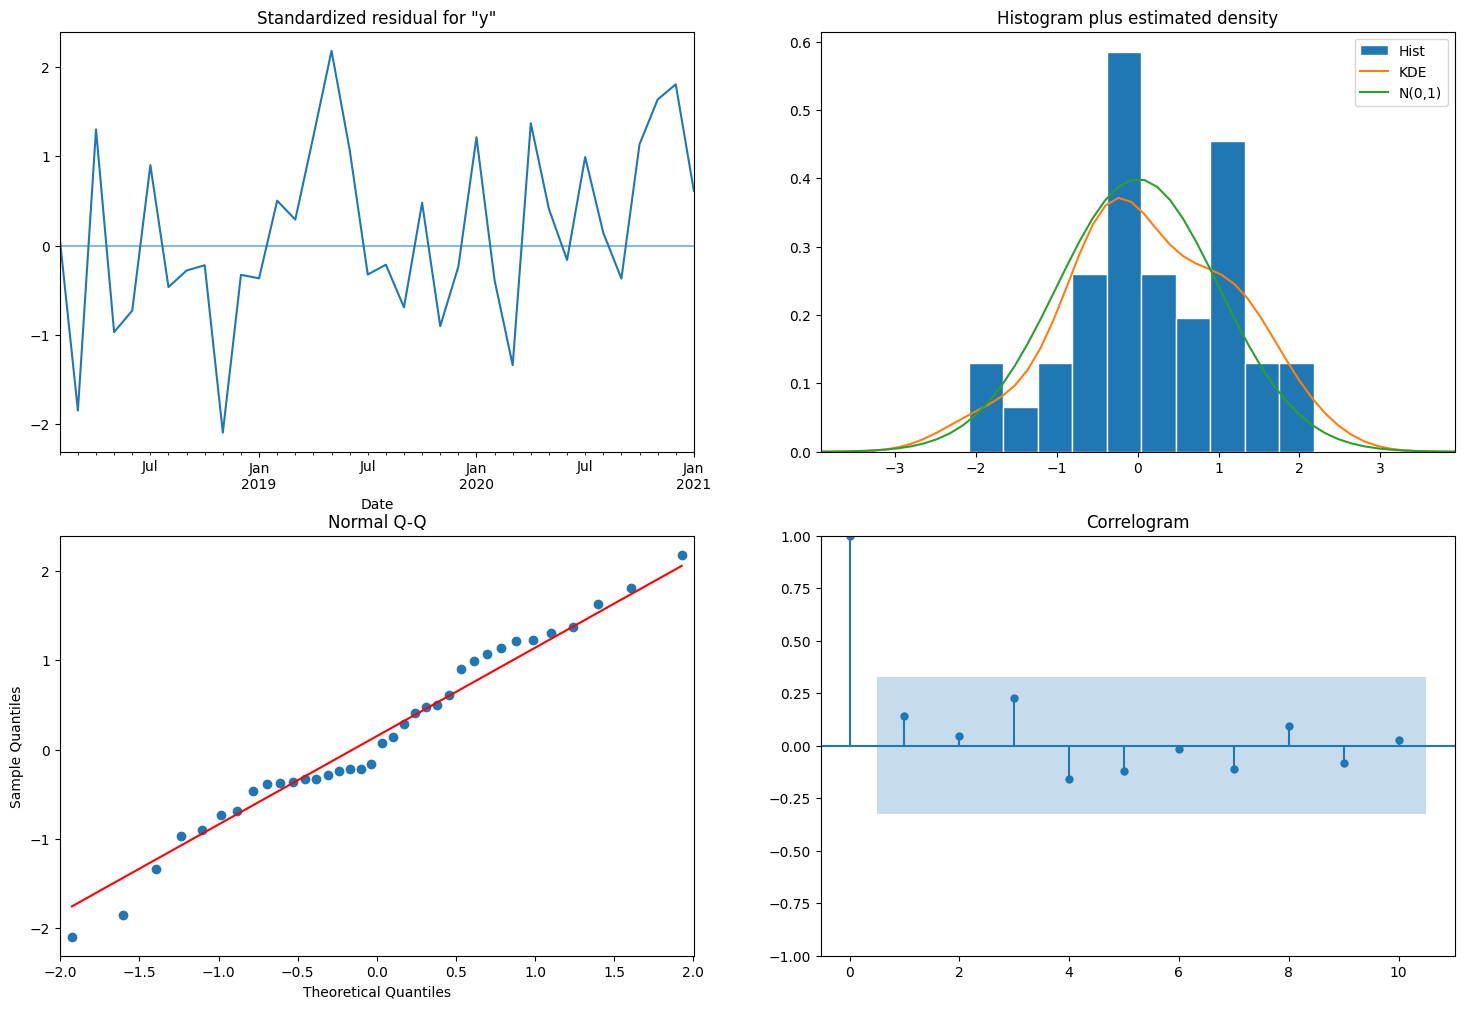

-------------------
PREVISÃO
-------------------


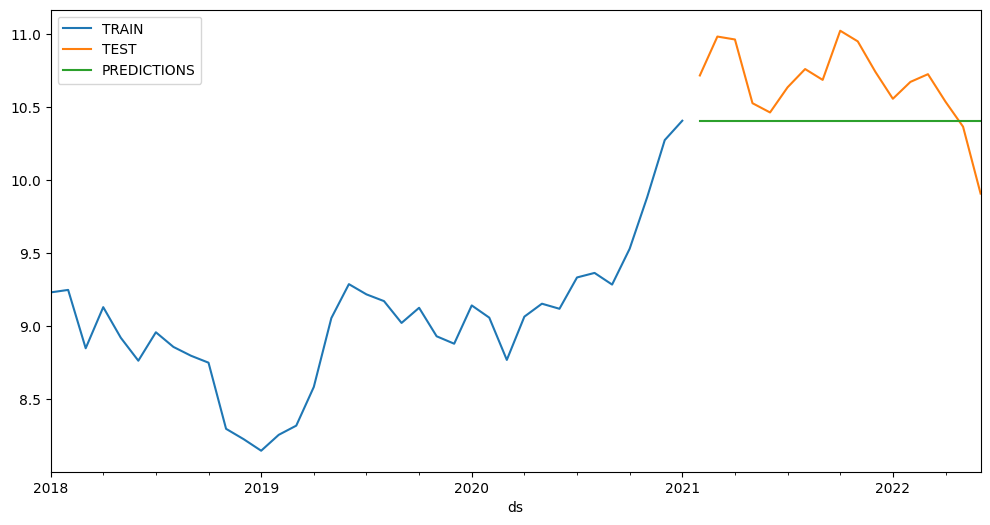

                          model           mse          rmse           mae  \
0  ARIMA(0,1,0)(single_testing)  2.258845e+08  15029.455918  12584.822266   

         r2       mape      smape  
0 -1.109025  27.443988  31.126584  
ARIMA(0,1,0)(incremental_testing)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------
MODELO
------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:                 ARIMA(0, 1, 0)   Log Likelihood                   6.456
Date:                Tue, 15 Apr 2025   AIC                            -10.911
Time:                        01:01:03   BIC                             -8.960
Sample:                             0   HQIC                           -10.163
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0457      0.010      4.424      0.000       0.025       0.066
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):                 0.53
Pr

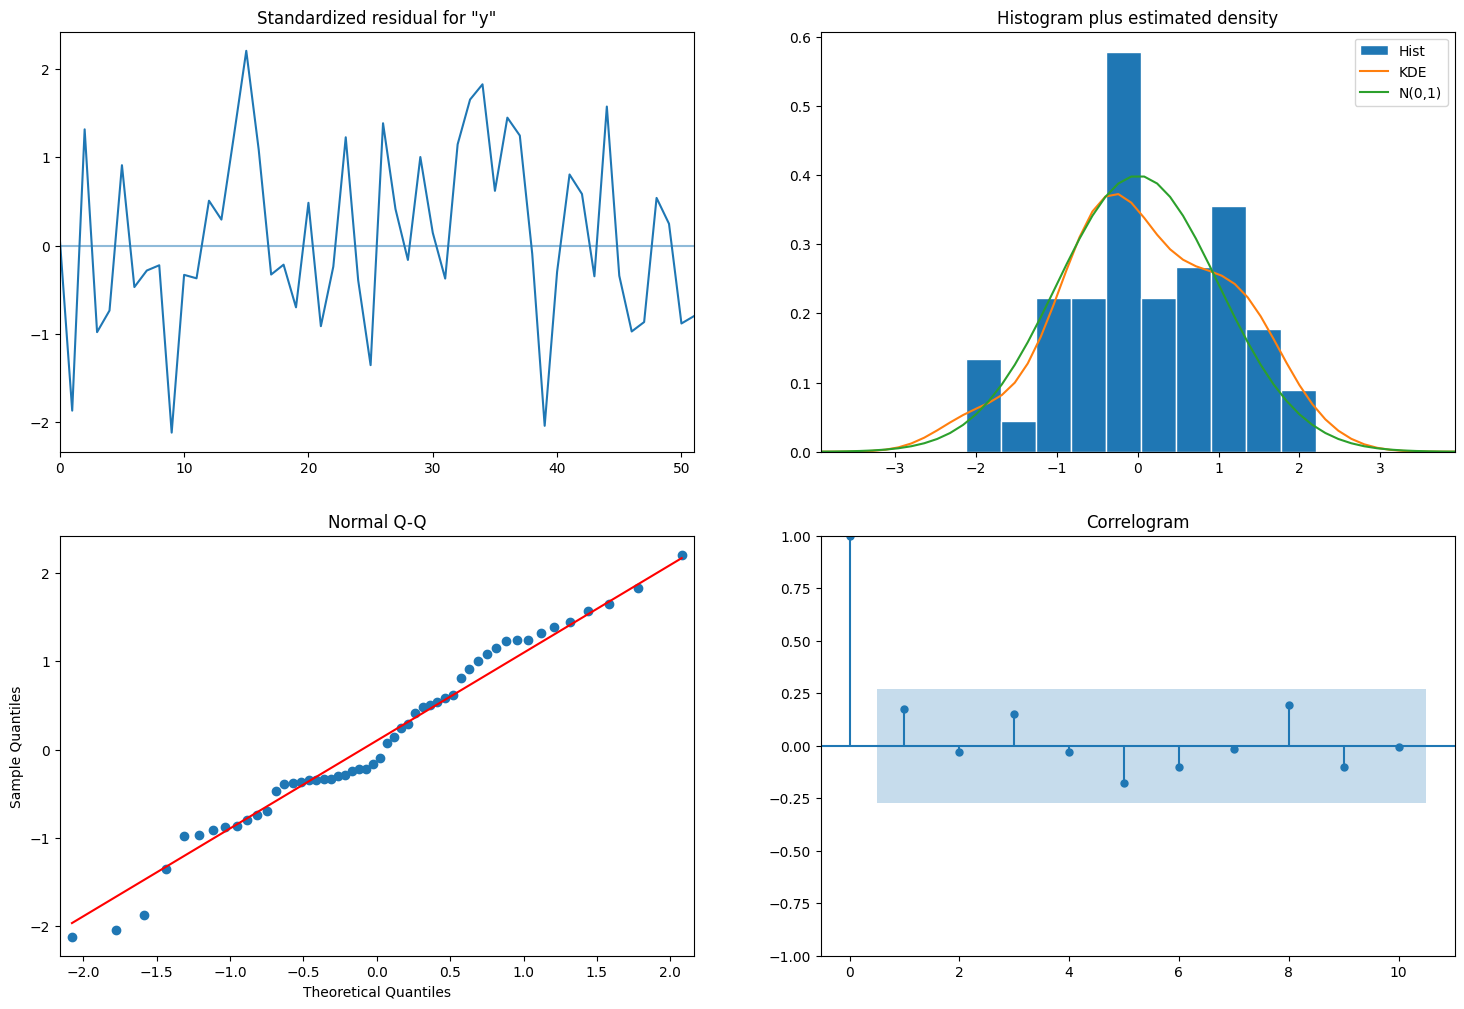

-------------------
PREVISÃO
-------------------


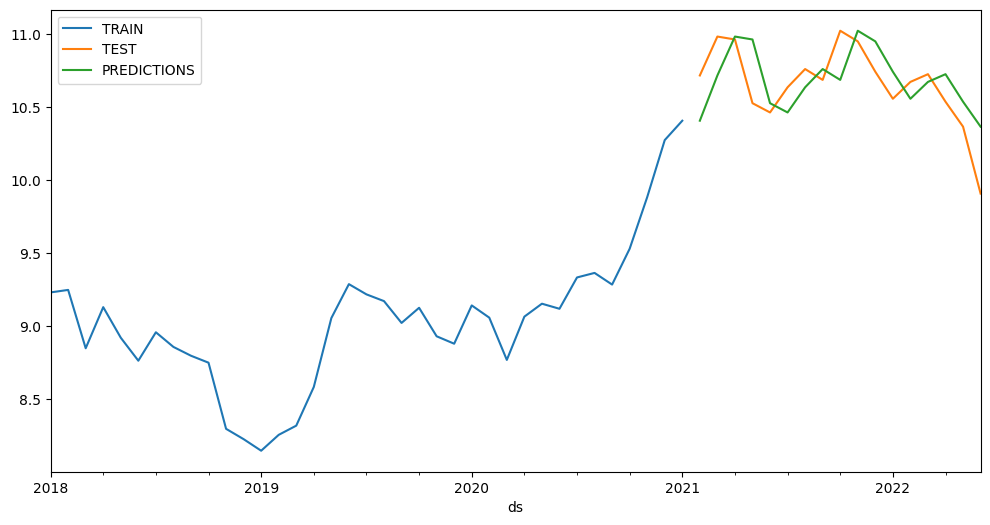

                               model           mse         rmse          mae  \
0  ARIMA(0,1,0)(incremental_testing)  9.444289e+07  9718.173108  8119.894761   

         r2       mape      smape  
0  0.118211  20.100648  19.005447  


In [ ]:
pred_arima010_met, arima010_met = model_evaluation(train, test, 0, 1, 0)

## AutoARIMA


In [ ]:

#Preparando os dados para o formato esperado pelos pacotes do StatsForecast
sf_train = train.reset_index().rename(columns={'Date':'ds'})
sf_train['unique_id'] = ticker
sf_train.head()

Ticker,ds,y,unique_id
0,2018-01-31,9.232209,BTC-USD
1,2018-02-28,9.249359,BTC-USD
2,2018-03-31,8.849877,BTC-USD
3,2018-04-30,9.131357,BTC-USD
4,2018-05-31,8.921881,BTC-USD


In [ ]:
models = [AutoARIMA()]
sf = StatsForecast(models=models, freq='M')
sf.fit(df=sf_train)
model_str = arima_string(sf.fitted_[0,0].model_)
print(f'Best ARIMA model: {model_str}')

Best ARIMA model: ARIMA(0,1,0)                   


In [ ]:
#import re
## Expressão regular para extrair p, d, q
#match = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', model_str)
#if match:
#  p, d, q = map(int, match.groups())
#  model_evaluation(train, test, p, d, q)
#else:
#  raise Exception('Erro na identificação dos hiper-parâmetros')

# Conclusion

In [ ]:
pred_arima010_met

,model,mse,rmse,mae,r2,mape,smape
0,"ARIMA(0,1,0)(single_testing)",2.258845e+08,15029.455918,12584.822266,-1.109025,27.443988,31.126584
0,"ARIMA(0,1,0)(incremental_testing)",9.444289e+07,9718.173108,8119.894761,0.118211,20.100648,19.005447


In [ ]:
arima010_met

,model,aic,bic,hqic,llf
0,"ARIMA(0,1,0)(single_testing)",-6.043520,-4.460002,-5.490830,4.021760
0,"ARIMA(0,1,0)(incremental_testing)",-10.911434,-8.960190,-10.163373,6.455717
